# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\poorna\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\poorna\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('D:/AAIC/Data_Sets/amazon-fine-food-reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 70000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (70000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(62864, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

89.80571428571429

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(62862, 10)


1    52600
0    10262
Name: Score, dtype: int64

In [15]:
df_majority = final[final.Score==1]
df_minority = final[final.Score==0]

#Referred: https://elitedatascience.com/imbalanced-classes
from sklearn.utils import resample

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.Score.value_counts()

1    52600
0    52600
Name: Score, dtype: int64

In [16]:
df_majority.shape[0]

52600

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = df_upsampled['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = df_upsampled['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = df_upsampled['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = df_upsampled['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
I'll always try to support a "Made In USA" product and/or a product distributed by a US business but the price/ounce for this product is high. Quality is very good. If you use Thyme Leaf in larger volumes go with the Frontier brand available here at Amazon. Two 1lb bags (32oz total) for about $17.00 currently and less with Subscribe & Save. That's a lot of product but it's also very good quality. I gave one bag to a friend of mine who owns a commercial bakery and he's hooked on Frontier now.<br />Again, if you only need an ounce for occasional home cooking this product is fine, and you're supporting a US business.
Great for when you are in too much of a hurry to cook breakfast or make a lunch.  The flavor is rich and chocolatey, add a bannana, a cup of 2% milk, blend it up and you are good to go.
These chunky peanut butter protein bars a

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
I'll always try to support a "Made In USA" product and/or a product distributed by a US business but the price/ounce for this product is high. Quality is very good. If you use Thyme Leaf in larger volumes go with the Frontier brand available here at Amazon. Two 1lb bags (32oz total) for about $17.00 currently and less with Subscribe & Save. That's a lot of product but it's also very good quality. I gave one bag to a friend of mine who owns a commercial bakery and he's hooked on Frontier now.Again, if you only need an ounce for occasional home cooking this product is fine, and you're supporting a US business.
Great for when you are in too much of a hurry to cook breakfast or make a lunch.  The flavor is rich and chocolatey, add a bannana, a cup of 2% milk, blend it up and you are good to go.
These chunky peanut butter protein bars are pre

In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great for when you are in too much of a hurry to cook breakfast or make a lunch.  The flavor is rich and chocolatey, add a bannana, a cup of 2% milk, blend it up and you are good to go.


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great for when you are in too much of a hurry to cook breakfast or make a lunch The flavor is rich and chocolatey add a bannana a cup of 2 milk blend it up and you are good to go 


In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df_upsampled['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████| 105200/105200 [00:54<00:00, 1940.89it/s]


In [26]:
preprocessed_reviews[1500]

'great much hurry cook breakfast make lunch flavor rich chocolatey add bannana cup milk blend good go'

In [27]:
len(preprocessed_reviews[1500].split())

17

In [31]:
preprocessed = pd.DataFrame(data=preprocessed_reviews, columns=['preprocessed_reviews'])

In [33]:
a = df_upsampled['Score'].values

In [34]:
a

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [35]:
preprocessed["Values"] = a

In [38]:
export_csv = preprocessed.to_csv (r'E:\Applied AI course\preprocessed.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path

In [39]:
export_csv

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [35]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [182]:
#divide preprocessed review data to Train and Test dataset using train_test_split
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train_bow, X_test_bow, Y_train_bow, Y_test_bow = train_test_split(preprocessed_reviews,df_upsampled['Score'].values,test_size=0.3,shuffle=True)
X_train_split_bow, X_CV_bow, Y_train_split_bow, Y_CV_bow = train_test_split(X_train_bow, Y_train_bow,test_size=0.2,shuffle=True)
#print(X_train.shape, Y_tra)
print(pd.DataFrame(Y_train_split_bow)[0].value_counts())
print(pd.DataFrame(Y_CV_bow)[0].value_counts())
print(pd.DataFrame(Y_test_bow)[0].value_counts())

1    29559
0    29353
Name: 0, dtype: int64
0    7376
1    7352
Name: 0, dtype: int64
0    15871
1    15689
Name: 0, dtype: int64


In [183]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train_split_bow)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_full_bow_vec = count_vect.transform(X_train_bow)
X_train_split_bow_vec = count_vect.transform(X_train_split_bow)
X_test_bow_vec = count_vect.transform(X_test_bow)
X_CV_bow_vec = count_vect.transform(X_CV_bow)
print("the type of count vectorizer ",type(X_train_split_bow_vec))
print("the shape of out text BOW vectorizer ",X_train_split_bow_vec.get_shape())
print("the number of unique words ", X_train_split_bow_vec.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand', 'aaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (58912, 37714)
the number of unique words  37714


In [184]:
base_esti = [1, 5, 10, 20, 30, 50, 100, 200, 400]

In [185]:
depth = [2, 8, 10,20, 30, 40, 50]

In [186]:
from sklearn.ensemble import RandomForestClassifier

df_heat_bow = pd.DataFrame(columns=['n_estimators','max_depth','AUC'])

In [187]:
def exec_RF(X_train_split_bow_vec, Y_train_split_bow, X_CV_bow_vec, Y_CV_bow, base_esti, depth):
        # Please write all the code with proper documentation
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.metrics import roc_auc_score, roc_curve, auc
        auc_rf_tr_bow = []
        auc_rf_cv_bow = []
        n_est_list = []
        depth_list = []
        XLabels=[]

        for n in tqdm(base_esti):
            for d in depth:
                XLabels.append(str(n)+"/"+str(d))
                clf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=0)
                clf.fit(X_train_split_bow_vec, Y_train_split_bow)
                Y_prd_prb_rf_tr_bow = clf.predict_proba(X_train_split_bow_vec)[:,1]
                temp_auc_rf_tr_bow = roc_auc_score(Y_train_split_bow, Y_prd_prb_rf_tr_bow)
                auc_rf_tr_bow.append(temp_auc_rf_tr_bow)
                Y_prd_prb_rf_cv_bow = clf.predict_proba(X_CV_bow_vec)[:,1]
                temp_auc_rf_cv_bow = roc_auc_score(Y_CV_bow, Y_prd_prb_rf_cv_bow)
                auc_rf_cv_bow.append(temp_auc_rf_cv_bow)
                n_est_list.append(n)
                depth_list.append(d)
                #print("N_estimators: %d and max_depth: %d --> AUC Train: %0.5f   AUC CV: %0.5f "%(n,d,temp_auc_rf_tr_bow,temp_auc_rf_cv_bow))
        
        return auc_rf_tr_bow,auc_rf_cv_bow,n_est_list,depth_list,XLabels


In [188]:
auc_rf_tr_bow,auc_rf_cv_bow,n_est_list,depth_list,XLabels = exec_RF(X_train_split_bow_vec, Y_train_split_bow, X_CV_bow_vec, Y_CV_bow, base_esti, depth)


100%|███████████████████████████████████████████| 9/9 [15:08<00:00, 205.00s/it]

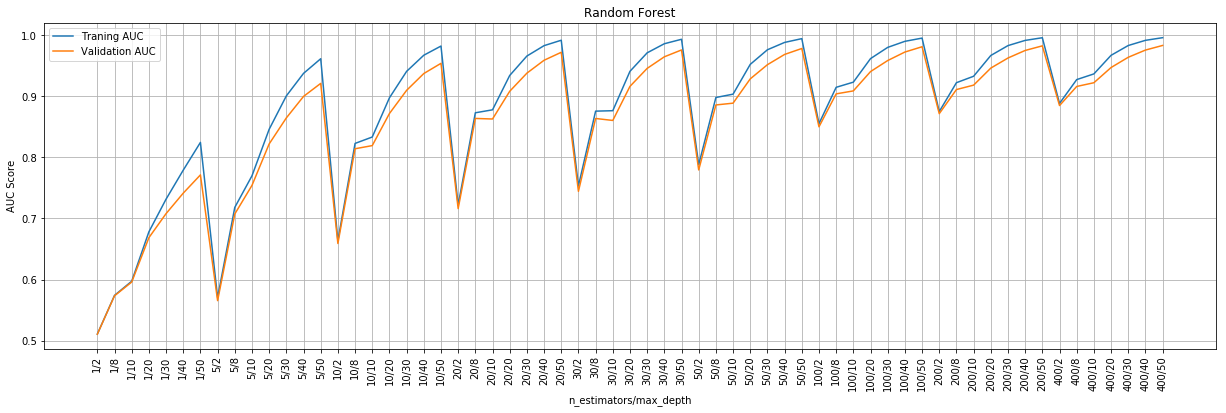

In [189]:
plt.figure(figsize=(21,6))
plt.plot(range(len(XLabels)), auc_rf_tr_bow)
plt.plot(range(len(XLabels)), auc_rf_cv_bow)
plt.xticks(range(len(XLabels)), XLabels, rotation = 90)
plt.grid(True)
plt.xlabel("n_estimators/max_depth")
plt.ylabel("AUC Score")
plt.title("Random Forest")
plt.legend(['Traning AUC', 'Validation AUC'])
plt.show()

In [190]:

RF_bow_opt = RandomForestClassifier(n_estimators=200, max_depth=50, random_state=0)
RF_bow_opt.fit(X_train_split_bow_vec, Y_train_split_bow)

Y_prd_prb_rf_tr_bow = RF_bow_opt.predict_proba(X_train_full_bow_vec)[:,1]
Y_prd_rf_tr_bow = RF_bow_opt.predict(X_train_full_bow_vec)
auc_opt_rf_tr_bow = roc_auc_score(Y_train_bow, Y_prd_prb_rf_tr_bow)

Y_prd_prb_rf_ts_bow = RF_bow_opt.predict_proba(X_test_bow_vec)[:,1]
Y_prd_rf_ts_bow = RF_bow_opt.predict(X_test_bow_vec)
auc_opt_rf_ts_bow = roc_auc_score(Y_test_bow, Y_prd_prb_rf_ts_bow)
print("AUC Train: %0.3f AUC Test: %0.3f "%(auc_opt_rf_tr_bow,auc_opt_rf_ts_bow))

AUC Train: 0.994 AUC Test: 0.982 


In [192]:
def plotROC(Y_Target_tr, Y_pred_tr, Y_target_ts, Y_pred_ts): 
    if Y_Target_tr is not None:
        fpr, tpr, _ = roc_curve(Y_Target_tr, Y_pred_tr)
        auc_tr = auc(fpr, tpr)
        plt.plot(fpr, tpr, 'b', label = 'AUC on train data = %0.3f' % auc_tr)

       
    fpr_test, tpr_test, _ = roc_curve(Y_target_ts, Y_pred_ts)
    auc_test = auc(fpr_test, tpr_test)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr_test, tpr_test, 'g', label = 'AUC on test data = %0.3f' % auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

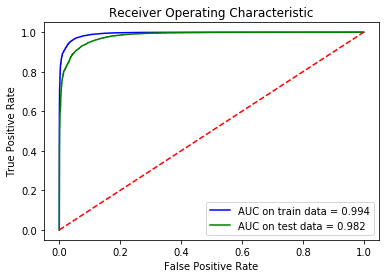

In [193]:
plotROC(Y_train_bow, Y_prd_prb_rf_tr_bow,Y_test_bow, Y_prd_prb_rf_ts_bow)

In [194]:
#confusion matirx
import scikitplot.metrics as skplt

def plotConfusion(Y_tr,Y_prob_tr, Y_ts, Y_prob_ts):
    # for train data prediction
    skplt.plot_confusion_matrix(Y_tr, Y_prob_tr)
    #for test data prediction
    skplt.plot_confusion_matrix(Y_ts, Y_prob_ts)

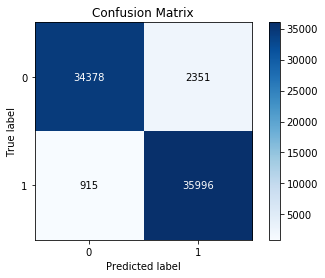

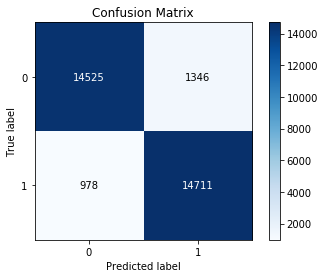

In [195]:
plotConfusion(Y_train_bow, Y_prd_rf_tr_bow,Y_test_bow, Y_prd_rf_ts_bow)

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [196]:
# Feature importance function for Decision Trees :
def show_most_informative_features(vectorizer, model):
    feat_names = vectorizer.get_feature_names()
    weights = model.feature_importances_
    df = pd.DataFrame(data = weights, columns=['Value'], index=feat_names)
    #df = pd.DataFrame(data = feat_names, columns=['Feature name'])
    df['Feature name'] = feat_names
    df.sort_values(by='Value', ascending=False, inplace=True)
    
    return df.head(20)

In [197]:
feat_top_20 = (show_most_informative_features(count_vect, RF_bow_opt))
#feat_top_20_list = feat_top_20.values.tolist()

In [198]:
feat_top_20

,Value,Feature name
not,0.028248,not
great,0.021885,great
best,0.011365,best
love,0.010794,love
delicious,0.009112,delicious
disappointed,0.008293,disappointed
would,0.007765,would
perfect,0.006986,perfect
bad,0.006971,bad
thought,0.006941,thought


In [199]:
feat_top_20_list = feat_top_20.values.tolist()

In [200]:
Feat_only=[]
for i in range(len(feat_top_20_list)):
   Feat_only.append(feat_top_20_list[:][i][1])

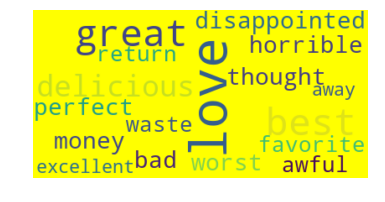

In [201]:
from wordcloud import WordCloud
joined = " ".join(Feat_only)

#ordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(feat_cloud)

# Display the generated image:


exec_word_cloud = WordCloud(max_font_size=60, max_words=90, background_color="yellow").generate(joined)
plt.imshow(exec_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [202]:
def Plot_Heatamp(depth_list,est_list,auc_list):
    #Create a dictionary
    pack_of_dict={'Depth_l':depth_list,'Split_l':est_list,'AUC_l':auc_list}
    #Creatign a dataframe from above dictionary
    df_packed=pd.DataFrame(pack_of_dict)
    df_pack_pivot=df_packed.pivot_table(index='Depth_l',columns='Split_l',values='AUC_l')
    sns.heatmap(df_pack_pivot,annot=True)
    plt.xlabel('Number of Estimators')
    plt.ylabel('Maximum Depth of Tree')
    plt.show()

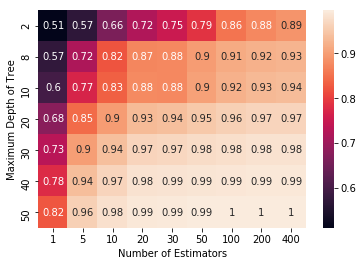

In [203]:
Plot_Heatamp(depth_list,n_est_list,auc_rf_tr_bow)

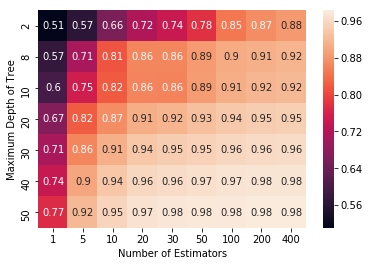

In [204]:
Plot_Heatamp(depth_list,n_est_list,auc_rf_cv_bow)

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [205]:
#divide preprocessed review data to Train and Test dataset using train_test_split
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train_tf, X_test_tf, Y_train_tf, Y_test_tf = train_test_split(preprocessed_reviews,df_upsampled['Score'].values,test_size=0.3,shuffle=True)
X_train_split_tf, X_CV_tf, Y_train_split_tf, Y_CV_tf = train_test_split(X_train_tf, Y_train_tf,test_size=0.2,shuffle=False)
#print(X_train.shape, Y_tra)
print(pd.DataFrame(Y_train_split_tf)[0].value_counts())
print(pd.DataFrame(Y_CV_tf)[0].value_counts())
print(pd.DataFrame(Y_test_tf)[0].value_counts())

0    29491
1    29421
Name: 0, dtype: int64
1    7407
0    7321
Name: 0, dtype: int64
0    15788
1    15772
Name: 0, dtype: int64


In [206]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train_split_tf)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_train_tf_full_vec = tf_idf_vect.transform(X_train_tf)
X_train_split_tf_vec = tf_idf_vect.transform(X_train_split_tf)
X_CV_tf_vec = tf_idf_vect.transform(X_CV_tf)
X_test_tf_vec = tf_idf_vect.transform(X_test_tf)

print("the type of count vectorizer ",type(X_train_split_tf_vec))
print("the shape of out text TFIDF vectorizer ",X_train_split_tf_vec.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_split_tf_vec.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aback', 'abandoned', 'abdominal', 'abilities', 'ability', 'able', 'able actually', 'able add', 'able buy']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (58912, 40905)
the number of unique words including both unigrams and bigrams  40905


In [207]:
#Training the model
auc_rf_tr_tf, auc_rf_cv_tf, n_est_list, depth_list, XLabels = exec_RF(X_train_split_tf_vec, Y_train_split_tf, X_CV_tf_vec, Y_CV_tf, base_esti, depth)


100%|███████████████████████████████████████████| 9/9 [21:05<00:00, 298.97s/it]

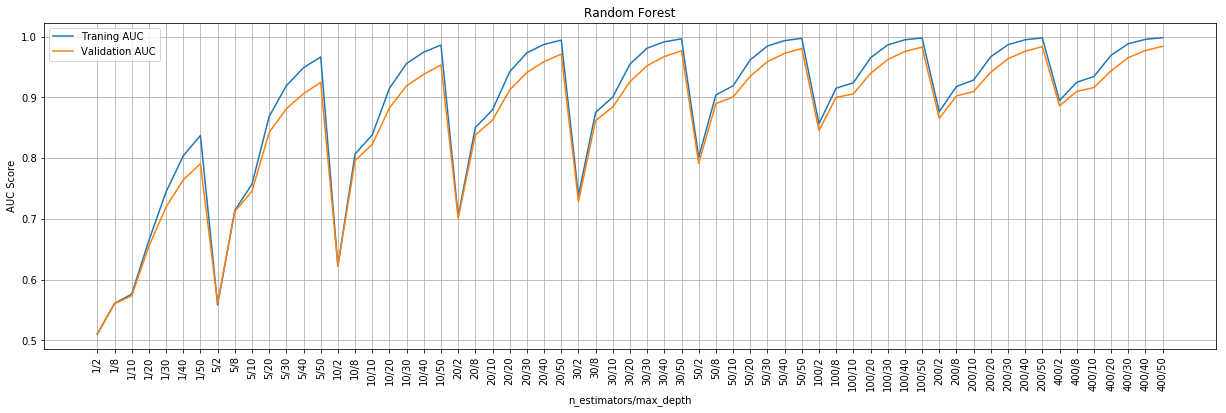

In [208]:
plt.figure(figsize=(21,6))
plt.plot(range(len(XLabels)), auc_rf_tr_tf)
plt.plot(range(len(XLabels)), auc_rf_cv_tf)
plt.xticks(range(len(XLabels)), XLabels, rotation = 90)
plt.grid(True)
plt.xlabel("n_estimators/max_depth")
plt.ylabel("AUC Score")
plt.title("Random Forest")
plt.legend(['Traning AUC', 'Validation AUC'])
plt.show()

In [224]:
RF_tf_opt = RandomForestClassifier(n_estimators=200, max_depth=50, random_state=0)
RF_tf_opt.fit(X_train_tf_full_vec, Y_train_tf)

Y_prd_prb_rf_tr_tf = RF_tf_opt.predict_proba(X_train_tf_full_vec)[:,1]
Y_prd_rf_tr_tf = RF_tf_opt.predict(X_train_tf_full_vec)
auc_opt_rf_tr_tf = roc_auc_score(Y_train_tf, Y_prd_prb_rf_tr_tf)

Y_prd_prb_rf_ts_tf = RF_tf_opt.predict_proba(X_test_tf_vec)[:,1]
Y_prd_rf_ts_tf = RF_tf_opt.predict(X_test_tf_vec)
auc_opt_rf_ts_tf = roc_auc_score(Y_test_tf, Y_prd_prb_rf_ts_tf)
print("AUC Train: %0.3f AUC Test: %0.3f "%(auc_opt_rf_tr_tf,auc_opt_rf_ts_tf))

AUC Train: 0.998 AUC Test: 0.987 


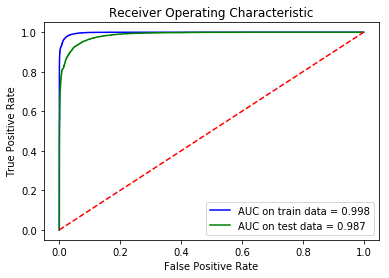

In [225]:
plotROC(Y_train_tf, Y_prd_prb_rf_tr_tf,Y_test_tf, Y_prd_prb_rf_ts_tf)

In [226]:
#confusion matirx
import scikitplot.metrics as skplt

def plotConfusion(Y_tr,Y_prob_tr, Y_ts, Y_prob_ts):
    # for train data prediction
    skplt.plot_confusion_matrix(Y_tr, Y_prob_tr)
    #for test data prediction
    skplt.plot_confusion_matrix(Y_ts, Y_prob_ts)

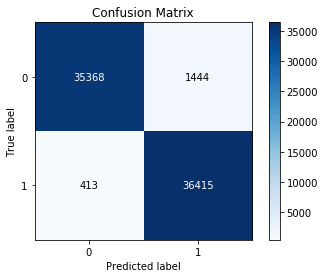

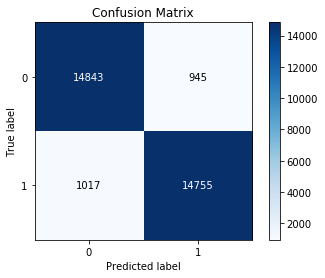

In [227]:
plotConfusion(Y_train_tf, Y_prd_rf_tr_tf,Y_test_tf, Y_prd_rf_ts_tf)

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [213]:
# Feature importance function for Decision Trees :
def show_most_informative_features(vectorizer, model):
    feat_names = vectorizer.get_feature_names()
    weights = model.feature_importances_
    df = pd.DataFrame(data = weights, columns=['Value'], index=feat_names)
    #df = pd.DataFrame(data = feat_names, columns=['Feature name'])
    df['Feature name'] = feat_names
    df.sort_values(by='Value', ascending=False, inplace=True)
    
    return df.head(20)

In [214]:
feat_top_20_tf = (show_most_informative_features(tf_idf_vect, RF_tf_opt))
#feat_top_20_list = feat_top_20.values.tolist()

In [215]:
feat_top_20_tf

,Value,Feature name
great,0.017125,great
disappointed,0.015857,disappointed
reviews,0.012379,reviews
good,0.012267,good
awful,0.010737,awful
best,0.010450,best
easy,0.009910,easy
opened,0.009433,opened
wonderful,0.008757,wonderful
return,0.008597,return


In [216]:
feat_top_20_list = feat_top_20_tf.values.tolist()

In [217]:
Feat_only=[]
for i in range(len(feat_top_20_list)):
   Feat_only.append(feat_top_20_list[:][i][1])

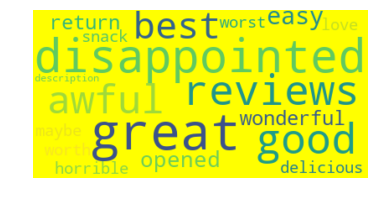

In [218]:
from wordcloud import WordCloud
joined = " ".join(Feat_only)

#ordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(feat_cloud)

# Display the generated image:


exec_word_cloud = WordCloud(max_font_size=60, max_words=90, background_color="yellow").generate(joined)
plt.imshow(exec_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [219]:
def Plot_Heatamp(depth_list,est_list,auc_list):
    #Create a dictionary
    pack_of_dict={'Depth_l':depth_list,'Split_l':est_list,'AUC_l':auc_list}
    #Creatign a dataframe from above dictionary
    df_packed=pd.DataFrame(pack_of_dict)
    df_pack_pivot=df_packed.pivot_table(index='Depth_l',columns='Split_l',values='AUC_l')
    sns.heatmap(df_pack_pivot,annot=True)
    plt.xlabel('Number of Estimators')
    plt.ylabel('Maximum Depth of Tree')
    plt.show()

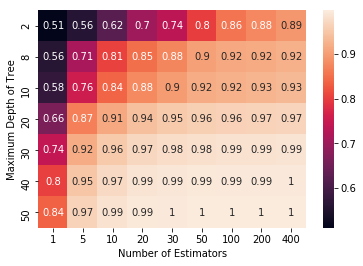

In [228]:
Plot_Heatamp(depth_list,n_est_list,auc_rf_tr_tf)

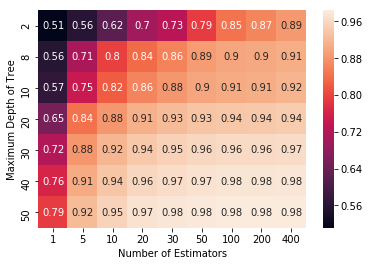

In [229]:
Plot_Heatamp(depth_list,n_est_list,auc_rf_cv_tf)

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [134]:
sent_vectors_train_aw = np.load("sent_vectors_train_aw.npy")
sent_vectors_CV_aw = np.load("sent_vectors_CV_aw.npy")
sent_vectors_test_aw = np.load("sent_vectors_test_aw.npy")
Y_train_split_aw = np.load("Y_train_split_aw.npy")
Y_CV_aw = np.load("Y_CV_aw.npy")
Y_test_aw = np.load("Y_test_aw.npy")

In [135]:
#Training the model
auc_rf_tr_aw, auc_rf_cv_aw, n_est_list, depth_list, XLabels = exec_RF(sent_vectors_train_aw, Y_train_split_aw, sent_vectors_CV_aw ,Y_CV_aw,base_esti, depth)


100%|███████████████████████████████████████████| 9/9 [33:23<00:00, 455.05s/it]

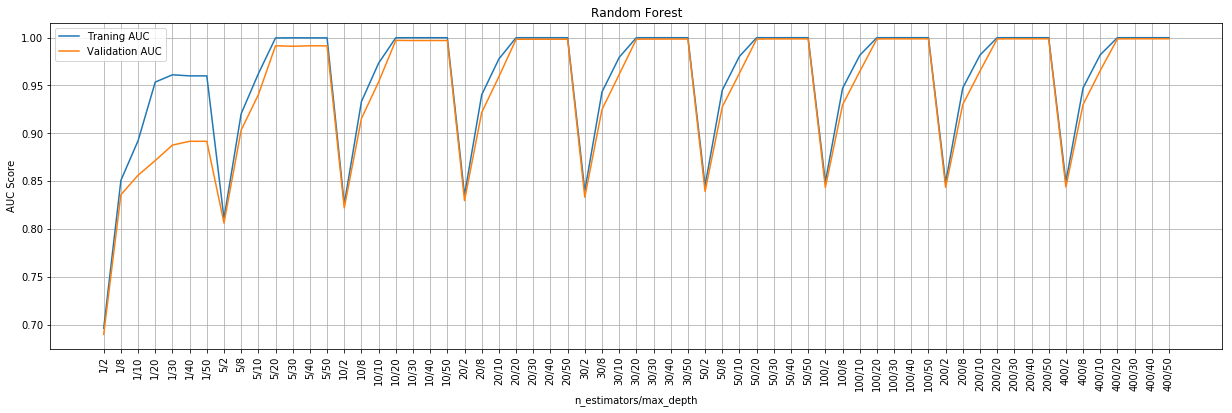

In [222]:
plt.figure(figsize=(21,6))
plt.plot(range(len(XLabels)), auc_rf_tr_aw)
plt.plot(range(len(XLabels)), auc_rf_cv_aw)
plt.xticks(range(len(XLabels)), XLabels, rotation = 90)
plt.grid(True)
plt.xlabel("n_estimators/max_depth")
plt.ylabel("AUC Score")
plt.title("Random Forest")
plt.legend(['Traning AUC', 'Validation AUC'])
plt.show()

In [223]:
sent_vectors_test_aw.shape

(33622, 50)

In [230]:
RF_aw_opt = RandomForestClassifier(n_estimators=10, max_depth=20, random_state=0)
RF_aw_opt.fit(sent_vectors_train_aw, Y_train_split_aw)

Y_prd_prb_rf_tr_aw = RF_aw_opt.predict_proba(sent_vectors_train_aw)[:,1]
Y_prd_rf_tr_aw = RF_aw_opt.predict(sent_vectors_train_aw)
auc_opt_rf_tr_aw = roc_auc_score(Y_train_split_aw, Y_prd_prb_rf_tr_aw)
 

Y_prd_prb_rf_ts_aw = RF_aw_opt.predict_proba(sent_vectors_test_aw)[:,1]
Y_prd_rf_ts_aw = RF_aw_opt.predict(sent_vectors_test_aw)
auc_opt_rf_ts_aw = roc_auc_score(Y_test_aw, Y_prd_prb_rf_ts_aw)
print("AUC Train: %0.3f AUC Test: %0.3f "%(auc_opt_rf_tr_aw,auc_opt_rf_ts_aw))

AUC Train: 1.000 AUC Test: 0.997 


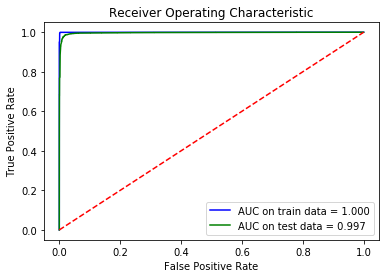

In [231]:
plotROC(Y_train_split_aw, Y_prd_prb_rf_tr_aw,Y_test_aw, Y_prd_prb_rf_ts_aw)

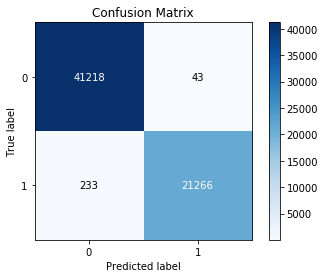

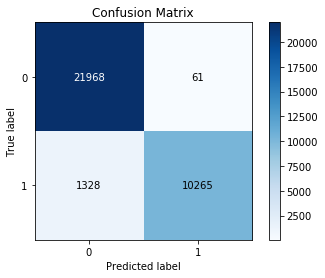

In [232]:
plotConfusion(Y_train_split_aw, Y_prd_rf_tr_aw, Y_test_aw, Y_prd_rf_ts_aw)

In [233]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

print("Precision of test: %0.4f"%(precision_score(Y_test_aw, Y_prd_rf_ts_aw)))
print("Recall of test: %0.4f"%(recall_score(Y_test_aw, Y_prd_rf_ts_aw)))
print("F1 Score of test: %0.4f"%(f1_score(Y_test_aw, Y_prd_rf_ts_aw)))

Precision of test: 0.9941
Recall of test: 0.8854
F1 Score of test: 0.9366


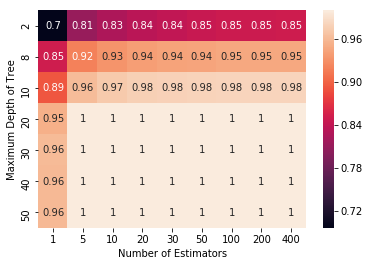

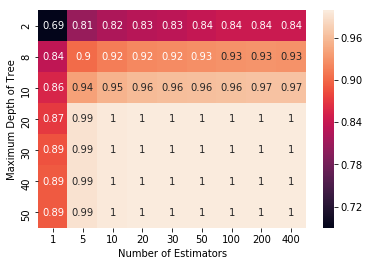

In [234]:
#Train
Plot_Heatamp(depth_list,n_est_list,auc_rf_tr_aw)
#CV
Plot_Heatamp(depth_list,n_est_list,auc_rf_cv_aw)

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [136]:
sent_vectors_train_tw = np.load("tfidf_sent_vectors_tw_train.npy")
sent_vectors_CV_tw = np.load("tfidf_sent_vectors_tw_CV.npy")
sent_vectors_test_tw = np.load("tfidf_sent_vectors_tw_test.npy")
Y_train_split_tw = np.load("Y_train_split_tw.npy")
Y_CV_tw = np.load("Y_CV_tw.npy")
Y_test_tw = np.load("Y_test_tw.npy")

In [137]:
#Training the model
auc_rf_tr_tw, auc_rf_cv_tw, n_est_list, depth_list, XLabels = exec_RF(sent_vectors_train_tw, Y_train_split_tw, sent_vectors_CV_tw ,Y_CV_aw,base_esti, depth)


100%|███████████████████████████████████████████| 9/9 [34:12<00:00, 467.50s/it]

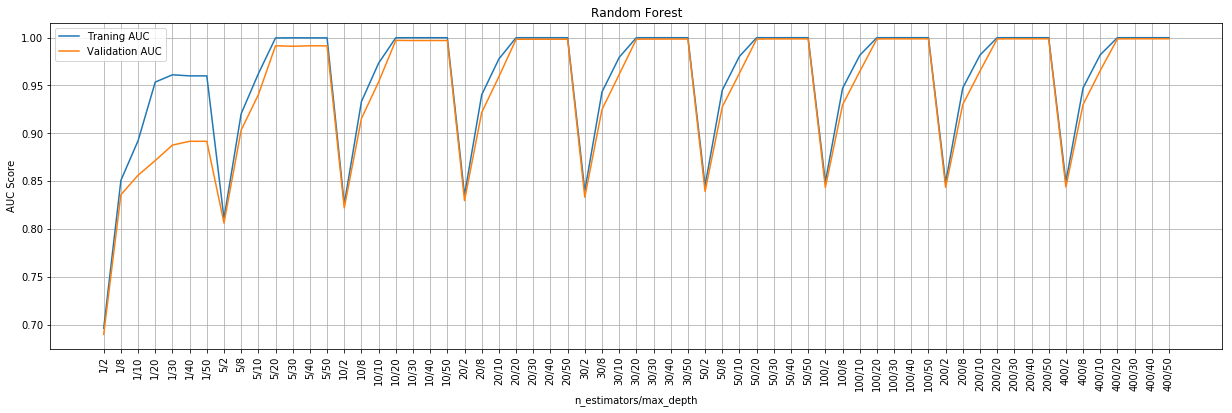

In [236]:
plt.figure(figsize=(21,6))
plt.plot(range(len(XLabels)), auc_rf_tr_tw)
plt.plot(range(len(XLabels)), auc_rf_cv_tw)
plt.xticks(range(len(XLabels)), XLabels, rotation = 90)
plt.grid(True)
plt.xlabel("n_estimators/max_depth")
plt.ylabel("AUC Score")
plt.title("Random Forest")
plt.legend(['Traning AUC', 'Validation AUC'])
plt.show()

In [237]:
RF_tw_opt = RandomForestClassifier(n_estimators=20, max_depth=20, random_state=0)
RF_tw_opt.fit(sent_vectors_train_tw, Y_train_split_tw)

Y_prd_prb_rf_tr_tw = RF_tw_opt.predict_proba(sent_vectors_train_tw)[:,1]
Y_prd_rf_tr_tw = RF_tw_opt.predict(sent_vectors_train_tw)
auc_opt_rf_tr_tw = roc_auc_score(Y_train_split_tw, Y_prd_prb_rf_tr_tw)
 

Y_prd_prb_rf_ts_tw = RF_tw_opt.predict_proba(sent_vectors_test_tw)[:,1]
Y_prd_rf_ts_tw = RF_tw_opt.predict(sent_vectors_test_tw)
auc_opt_rf_ts_tw = roc_auc_score(Y_test_tw, Y_prd_prb_rf_ts_tw)
print("AUC Train: %0.3f AUC Test: %0.3f "%(auc_opt_rf_tr_tw,auc_opt_rf_ts_tw))

AUC Train: 1.000 AUC Test: 0.998 


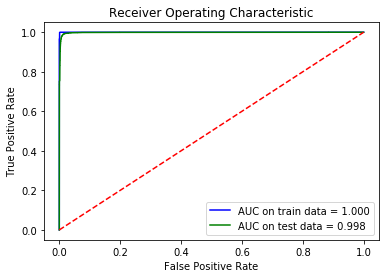

In [238]:
plotROC(Y_train_split_tw, Y_prd_prb_rf_tr_tw,Y_test_tw, Y_prd_prb_rf_ts_tw)

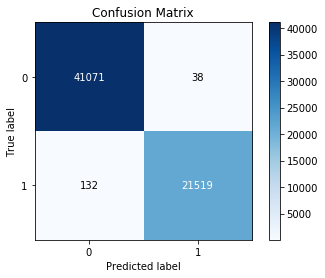

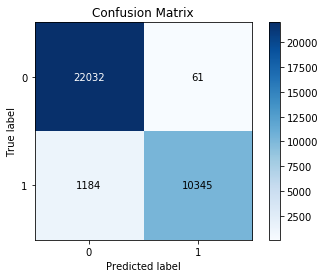

In [239]:
plotConfusion(Y_train_split_tw, Y_prd_rf_tr_tw, Y_test_tw, Y_prd_rf_ts_tw)

In [240]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

print("Precision of test: %0.4f"%(precision_score(Y_test_tw, Y_prd_rf_ts_tw)))
print("Recall of test: %0.4f"%(recall_score(Y_test_tw, Y_prd_rf_ts_tw)))
print("F1 Score of test: %0.4f"%(f1_score(Y_test_tw, Y_prd_rf_ts_tw)))

Precision of test: 0.9941
Recall of test: 0.8973
F1 Score of test: 0.9432


## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [138]:
from xgboost import XGBClassifier as XGB

In [139]:
#divide preprocessed review data to Train and Test dataset using train_test_split
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train_bow, X_test_bow, Y_train_bow, Y_test_bow = train_test_split(preprocessed_reviews,df_upsampled['Score'].values,test_size=0.3,shuffle=True)
X_train_split_bow, X_CV_bow, Y_train_split_bow, Y_CV_bow = train_test_split(X_train_bow, Y_train_bow,test_size=0.2,shuffle=False)
#print(X_train.shape, Y_tra)
print(pd.DataFrame(Y_train_split_bow)[0].value_counts())
print(pd.DataFrame(Y_CV_bow)[0].value_counts())
print(pd.DataFrame(Y_test_bow)[0].value_counts())

1    21519
0     2368
Name: 0, dtype: int64
1    5388
0     584
Name: 0, dtype: int64
1    11572
0     1226
Name: 0, dtype: int64


In [140]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train_split_bow)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_full_bow_vec = count_vect.transform(X_train_bow)
X_train_split_bow_vec = count_vect.transform(X_train_split_bow)
X_test_bow_vec = count_vect.transform(X_test_bow)
X_CV_bow_vec = count_vect.transform(X_CV_bow)
print("the type of count vectorizer ",type(X_train_split_bow_vec))
print("the shape of out text BOW vectorizer ",X_train_split_bow_vec.get_shape())
print("the number of unique words ", X_train_split_bow_vec.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aachen', 'aadp', 'aaf', 'aafco']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (23887, 28562)
the number of unique words  28562


In [141]:
base_esti = [1, 5, 10, 20, 30, 50, 100, 200, 400]

In [142]:
depth = [2, 8, 10,20, 30, 40, 50]

In [143]:
df_heat_bow = pd.DataFrame(columns=['n_estimators','max_depth','AUC'])

In [144]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate until the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [145]:
def exec_xg(X_train_split_bow_vec, Y_train_split_bow, X_CV_bow_vec, Y_CV_bow, base_esti, depth):
        # Please write all the code with proper documentation
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.metrics import roc_auc_score, roc_curve, auc
        auc_rf_tr_bow = []
        auc_rf_cv_bow = []
        n_est_list = []
        depth_list = []
        XLabels=[]

        for n in tqdm(base_esti):
            for d in depth:
                XLabels.append(str(n)+"/"+str(d))
                clf = XGB(n_estimators=n, max_depth=d, random_state=0)
                clf.fit(X_train_split_bow_vec, Y_train_split_bow)
                Y_prd_prb_rf_tr_bow = batch_predict(clf, X_train_split_bow_vec)
                temp_auc_rf_tr_bow = roc_auc_score(Y_train_split_bow, Y_prd_prb_rf_tr_bow)
                auc_rf_tr_bow.append(temp_auc_rf_tr_bow)
                Y_prd_prb_rf_cv_bow = batch_predict(clf, X_CV_bow_vec)
                temp_auc_rf_cv_bow = roc_auc_score(Y_CV_bow, Y_prd_prb_rf_cv_bow)
                auc_rf_cv_bow.append(temp_auc_rf_cv_bow)
                n_est_list.append(n)
                depth_list.append(d)
                #print("N_estimators: %d and max_depth: %d --> AUC Train: %0.5f   AUC CV: %0.5f "%(n,d,temp_auc_rf_tr_bow,temp_auc_rf_cv_bow))
        
        return auc_rf_tr_bow,auc_rf_cv_bow,n_est_list,depth_list,XLabels


In [146]:
auc_xg_tr_bow,auc_xg_cv_bow,n_est_list,depth_list,XLabels = exec_xg(X_train_split_bow_vec, Y_train_split_bow, X_CV_bow_vec, Y_CV_bow, base_esti, depth)


100%|███████████████████████████████████████████| 9/9 [41:47<00:00, 549.42s/it]

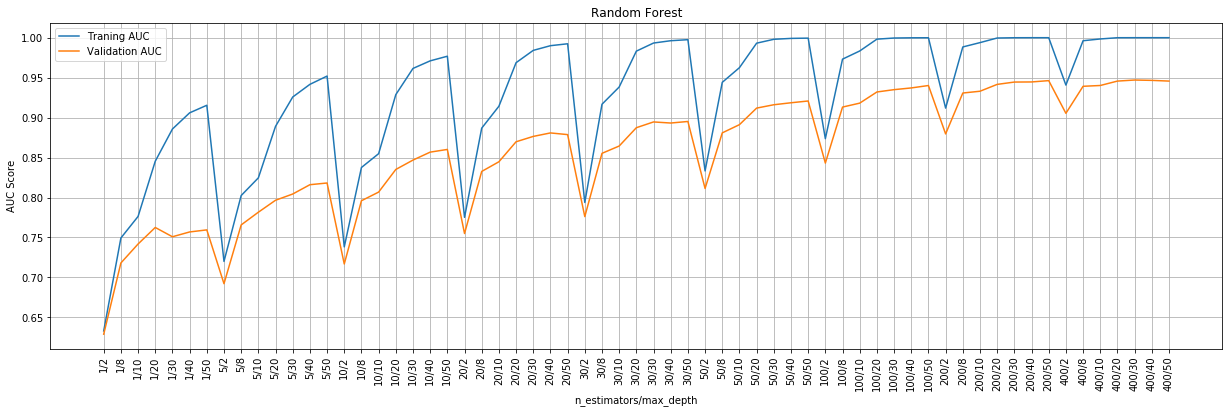

In [243]:
plt.figure(figsize=(21,6))
plt.plot(range(len(XLabels)), auc_xg_tr_bow)
plt.plot(range(len(XLabels)), auc_xg_cv_bow)
plt.xticks(range(len(XLabels)), XLabels, rotation = 90)
plt.grid(True)
plt.xlabel("n_estimators/max_depth")
plt.ylabel("AUC Score")
plt.title("Random Forest")
plt.legend(['Traning AUC', 'Validation AUC'])
plt.show()

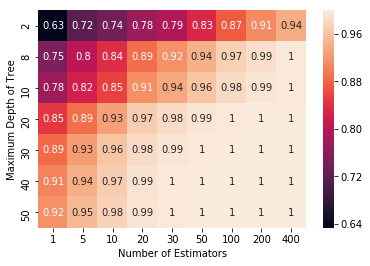

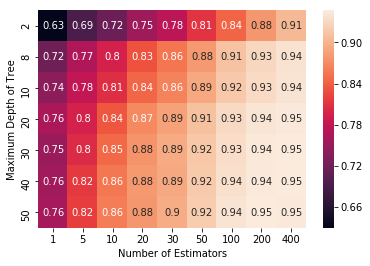

In [244]:
#Train
Plot_Heatamp(depth_list,n_est_list,auc_xg_tr_bow)
#CV
Plot_Heatamp(depth_list,n_est_list,auc_xg_cv_bow)

In [245]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
XG_bow_opt = XGB(n_estimators=200, max_depth=50, random_state=0)
XG_bow_opt.fit(X_train_split_bow_vec, Y_train_split_bow)

Y_prd_prb_xg_tr_bow = XG_bow_opt.predict_proba(X_train_full_bow_vec)[:,1]
Y_prd_xg_tr_bow = XG_bow_opt.predict(X_train_full_bow_vec)
auc_opt_xg_tr_bow = roc_auc_score(Y_train_bow, Y_prd_prb_xg_tr_bow)

Y_prd_prb_xg_ts_bow = XG_bow_opt.predict_proba(X_test_bow_vec)[:,1]
Y_prd_xg_ts_bow = XG_bow_opt.predict(X_test_bow_vec)
auc_opt_xg_ts_bow = roc_auc_score(Y_test_bow, Y_prd_prb_xg_ts_bow)
print("AUC Train: %0.3f AUC Test: %0.3f "%(auc_opt_xg_tr_bow,auc_opt_xg_ts_bow))

AUC Train: 0.999 AUC Test: 0.993 


In [247]:
def plotROC(Y_Target_tr, Y_pred_tr, Y_target_ts, Y_pred_ts): 
    if Y_Target_tr is not None:
        fpr, tpr, _ = roc_curve(Y_Target_tr, Y_pred_tr)
        auc_tr = auc(fpr, tpr)
        plt.plot(fpr, tpr, 'b', label = 'AUC on train data = %0.3f' % auc_tr)

       
    fpr_test, tpr_test, _ = roc_curve(Y_target_ts, Y_pred_ts)
    auc_test = auc(fpr_test, tpr_test)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr_test, tpr_test, 'g', label = 'AUC on test data = %0.3f' % auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

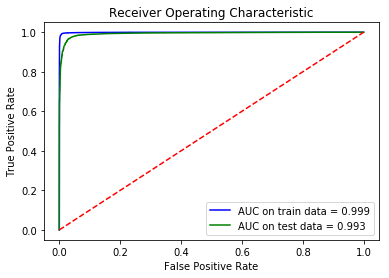

In [248]:
plotROC(Y_train_bow, Y_prd_prb_xg_tr_bow,Y_test_bow, Y_prd_prb_xg_ts_bow)

In [249]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

print("Precision of test: %0.4f"%(precision_score(Y_test_bow, Y_prd_xg_ts_bow)))
print("Recall of test: %0.4f"%(recall_score(Y_test_bow, Y_prd_xg_ts_bow)))
print("F1 Score of test: %0.4f"%(f1_score(Y_test_bow, Y_prd_xg_ts_bow)))

Precision of test: 0.9797
Recall of test: 0.9383
F1 Score of test: 0.9586


In [250]:
#confusion matirx
import scikitplot.metrics as skplt

def plotConfusion(Y_tr,Y_prob_tr, Y_ts, Y_prob_ts):
    # for train data prediction
    skplt.plot_confusion_matrix(Y_tr, Y_prob_tr)
    #for test data prediction
    skplt.plot_confusion_matrix(Y_ts, Y_prob_ts)

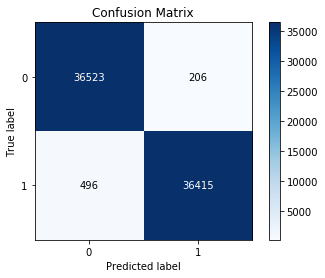

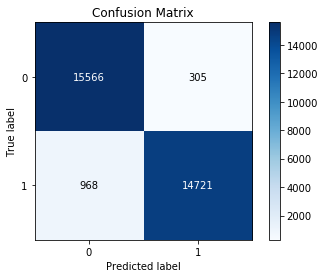

In [251]:
plotConfusion(Y_train_bow, Y_prd_xg_tr_bow,Y_test_bow, Y_prd_xg_ts_bow)

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [147]:
#divide preprocessed review data to Train and Test dataset using train_test_split
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train_tf, X_test_tf, Y_train_tf, Y_test_tf = train_test_split(preprocessed_reviews,df_upsampled['Score'].values,test_size=0.3,shuffle=True)
X_train_split_tf, X_CV_tf, Y_train_split_tf, Y_CV_tf = train_test_split(X_train_tf, Y_train_tf,test_size=0.2,shuffle=False)
#print(X_train.shape, Y_tra)
print(pd.DataFrame(Y_train_split_tf)[0].value_counts())
print(pd.DataFrame(Y_CV_tf)[0].value_counts())
print(pd.DataFrame(Y_test_tf)[0].value_counts())

1    21516
0     2371
Name: 0, dtype: int64
1    5401
0     571
Name: 0, dtype: int64
1    11562
0     1236
Name: 0, dtype: int64


In [148]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train_split_tf)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_train_tf_full_vec = tf_idf_vect.transform(X_train_tf)
X_train_split_tf_vec = tf_idf_vect.transform(X_train_split_tf)
X_CV_tf_vec = tf_idf_vect.transform(X_CV_tf)
X_test_tf_vec = tf_idf_vect.transform(X_test_tf)

print("the type of count vectorizer ",type(X_train_split_tf_vec))
print("the shape of out text TFIDF vectorizer ",X_train_split_tf_vec.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_split_tf_vec.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able get', 'able make', 'able order']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (23887, 14224)
the number of unique words including both unigrams and bigrams  14224


In [149]:
#Training the model
auc_xg_tr_tf, auc_xg_cv_tf, n_est_list, depth_list, XLabels = exec_xg(X_train_split_tf_vec, Y_train_split_tf, X_CV_tf_vec, Y_CV_tf, base_esti, depth)


100%|█████████████████████████████████████████| 9/9 [1:08:48<00:00, 896.98s/it]

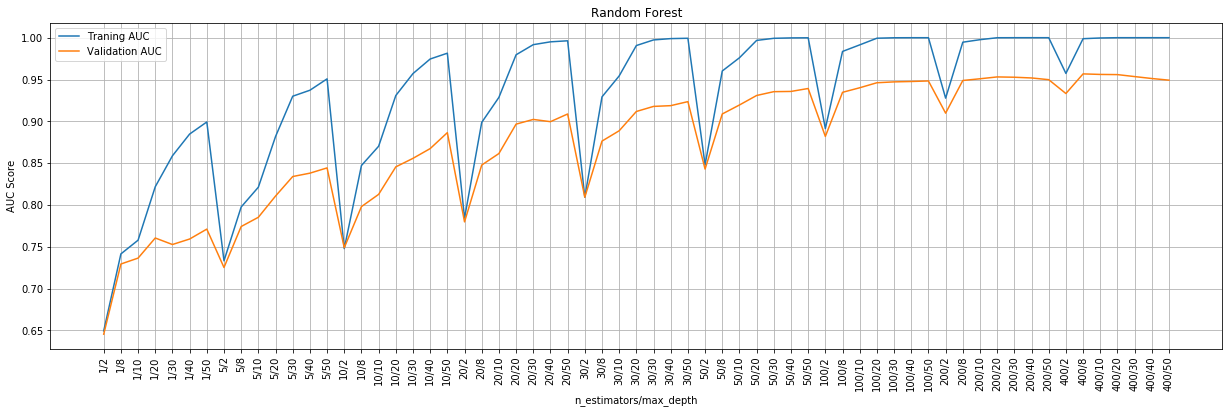

In [150]:
plt.figure(figsize=(21,6))
plt.plot(range(len(XLabels)), auc_xg_tr_tf)
plt.plot(range(len(XLabels)), auc_xg_cv_tf)
plt.xticks(range(len(XLabels)), XLabels, rotation = 90)
plt.grid(True)
plt.xlabel("n_estimators/max_depth")
plt.ylabel("AUC Score")
plt.title("Random Forest")
plt.legend(['Traning AUC', 'Validation AUC'])
plt.show()

In [68]:
XG_tf_opt = XGB(n_estimators=200, max_depth=20, random_state=0)
XG_tf_opt.fit(X_train_tf_full_vec, Y_train_tf)

Y_prd_prb_xg_tr_tf = XG_tf_opt.predict_proba(X_train_tf_full_vec)[:,1]
Y_prd_xg_tr_tf = XG_tf_opt.predict(X_train_tf_full_vec)
auc_opt_xg_tr_tf = roc_auc_score(Y_train_tf, Y_prd_prb_xg_tr_tf)

Y_prd_prb_xg_ts_tf = XG_tf_opt.predict_proba(X_test_tf_vec)[:,1]
Y_prd_xg_ts_tf = XG_tf_opt.predict(X_test_tf_vec)
auc_opt_xg_ts_tf = roc_auc_score(Y_test_tf, Y_prd_prb_xg_ts_tf)
print("AUC Train: %0.3f AUC Test: %0.3f "%(auc_opt_xg_tr_tf,auc_opt_xg_ts_tf))

AUC Train: 0.997 AUC Test: 0.978 


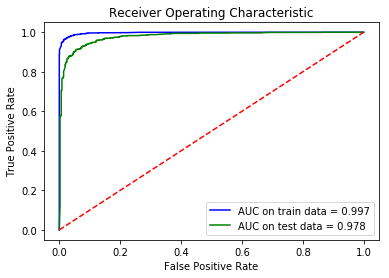

In [69]:
plotROC(Y_train_tf, Y_prd_prb_xg_tr_tf,Y_test_tf, Y_prd_prb_xg_ts_tf)

In [70]:
#confusion matirx
import scikitplot.metrics as skplt

def plotConfusion(Y_tr,Y_prob_tr, Y_ts, Y_prob_ts):
    # for train data prediction
    skplt.plot_confusion_matrix(Y_tr, Y_prob_tr)
    #for test data prediction
    skplt.plot_confusion_matrix(Y_ts, Y_prob_ts)

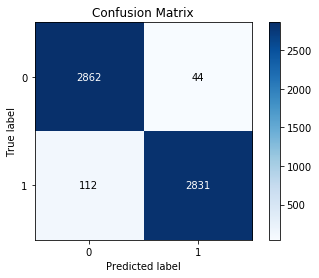

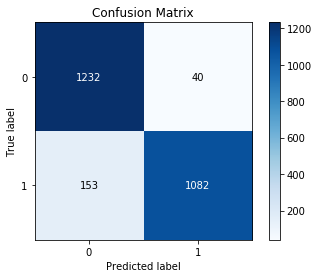

In [71]:
plotConfusion(Y_train_tf, Y_prd_xg_tr_tf,Y_test_tf, Y_prd_xg_ts_tf)

In [73]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

print("Precision of test: %0.4f"%(precision_score(Y_test_tf, Y_prd_xg_ts_tf)))
print("Recall of test: %0.4f"%(recall_score(Y_test_tf, Y_prd_xg_ts_tf)))
print("F1 Score of test: %0.4f"%(f1_score(Y_test_tf, Y_prd_xg_ts_tf)))

Precision of test: 0.9643
Recall of test: 0.8761
F1 Score of test: 0.9181


### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [74]:
sent_vectors_train_aw = np.load("sent_vectors_train_aw.npy")
sent_vectors_CV_aw = np.load("sent_vectors_CV_aw.npy")
sent_vectors_test_aw = np.load("sent_vectors_test_aw.npy")
Y_train_split_aw = np.load("Y_train_split_aw.npy")
Y_CV_aw = np.load("Y_CV_aw.npy")
Y_test_aw = np.load("Y_test_aw.npy")

In [75]:
#Training the model
auc_xg_tr_aw, auc_xg_cv_aw, n_est_list, depth_list, XLabels = exec_xg(sent_vectors_train_aw, Y_train_split_aw, sent_vectors_CV_aw ,Y_CV_aw,base_esti, depth)


100%|████████████████████████████████████████| 9/9 [1:20:14<00:00, 1065.16s/it]

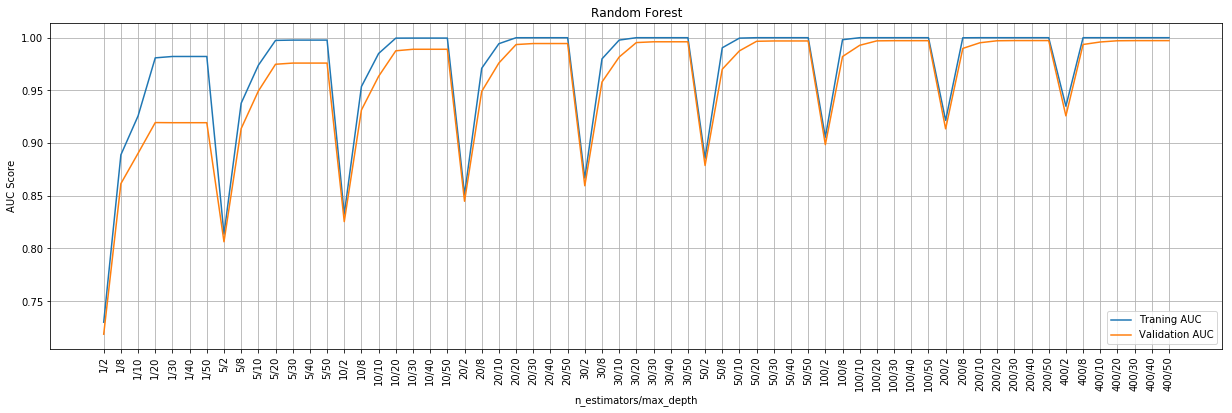

In [76]:
plt.figure(figsize=(21,6))
plt.plot(range(len(XLabels)), auc_xg_tr_aw)
plt.plot(range(len(XLabels)), auc_xg_cv_aw)
plt.xticks(range(len(XLabels)), XLabels, rotation = 90)
plt.grid(True)
plt.xlabel("n_estimators/max_depth")
plt.ylabel("AUC Score")
plt.title("Random Forest")
plt.legend(['Traning AUC', 'Validation AUC'])
plt.show()

In [77]:
sent_vectors_test_aw.shape

(33622, 50)

In [262]:
XG_aw_opt = XGB(n_estimators=200, max_depth=40, random_state=0)
XG_aw_opt.fit(sent_vectors_train_aw, Y_train_split_aw)

Y_prd_prb_xg_tr_aw = XG_aw_opt.predict_proba(sent_vectors_train_aw)[:,1]
Y_prd_xg_tr_aw = XG_aw_opt.predict(sent_vectors_train_aw)
auc_opt_xg_tr_aw = roc_auc_score(Y_train_split_aw, Y_prd_prb_xg_tr_aw)
 

Y_prd_prb_xg_ts_aw = XG_aw_opt.predict_proba(sent_vectors_test_aw)[:,1]
Y_prd_xg_ts_aw = XG_aw_opt.predict(sent_vectors_test_aw)
auc_opt_xg_ts_aw = roc_auc_score(Y_test_aw, Y_prd_prb_xg_ts_aw)
print("AUC Train: %0.3f AUC Test: %0.3f "%(auc_opt_xg_tr_aw,auc_opt_xg_ts_aw))

AUC Train: 1.000 AUC Test: 0.998 


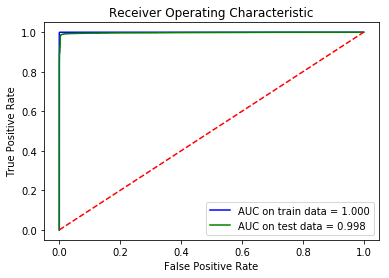

In [263]:
plotROC(Y_train_split_aw, Y_prd_prb_xg_tr_aw,Y_test_aw, Y_prd_prb_xg_ts_aw)

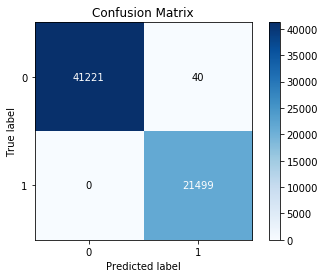

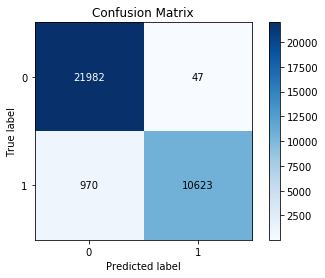

In [264]:
plotConfusion(Y_train_split_aw, Y_prd_xg_tr_aw, Y_test_aw, Y_prd_xg_ts_aw)

In [265]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

print("Precision of test: %0.4f"%(precision_score(Y_test_aw, Y_prd_xg_ts_aw)))
print("Recall of test: %0.4f"%(recall_score(Y_test_aw, Y_prd_xg_ts_aw)))
print("F1 Score of test: %0.4f"%(f1_score(Y_test_aw, Y_prd_xg_ts_aw)))

Precision of test: 0.9956
Recall of test: 0.9163
F1 Score of test: 0.9543


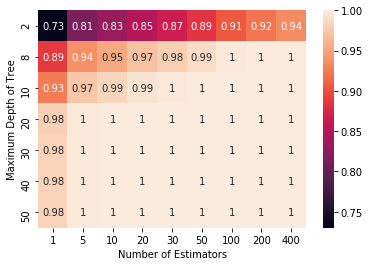

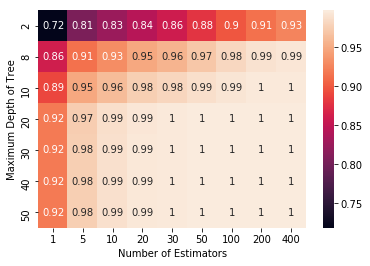

In [266]:
#Train
Plot_Heatamp(depth_list,n_est_list,auc_xg_tr_aw)
#CV
Plot_Heatamp(depth_list,n_est_list,auc_xg_cv_aw)

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [78]:
sent_vectors_train_tw = np.load("tfidf_sent_vectors_tw_train.npy")
sent_vectors_CV_tw = np.load("tfidf_sent_vectors_tw_CV.npy")
sent_vectors_test_tw = np.load("tfidf_sent_vectors_tw_test.npy")
Y_train_split_tw = np.load("Y_train_split_tw.npy")
Y_CV_tw = np.load("Y_CV_tw.npy")
Y_test_tw = np.load("Y_test_tw.npy")

In [80]:
#Training the model
auc_xg_tr_tw, auc_xg_cv_tw, n_est_list, depth_list, XLabels = exec_xg(sent_vectors_train_tw, Y_train_split_tw, sent_vectors_CV_tw ,Y_CV_aw,base_esti, depth)


100%|████████████████████████████████████████| 9/9 [1:24:57<00:00, 1101.03s/it]

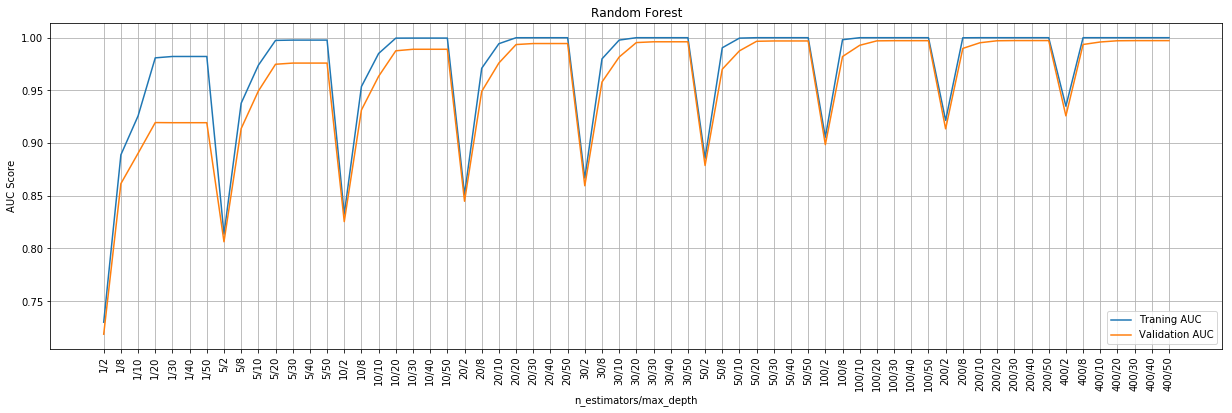

In [246]:
plt.figure(figsize=(21,6))
plt.plot(range(len(XLabels)), auc_xg_tr_tw)
plt.plot(range(len(XLabels)), auc_xg_cv_tw)
plt.xticks(range(len(XLabels)), XLabels, rotation = 90)
plt.grid(True)
plt.xlabel("n_estimators/max_depth")
plt.ylabel("AUC Score")
plt.title("Random Forest")
plt.legend(['Traning AUC', 'Validation AUC'])
plt.show()

In [261]:
XG_tw_opt = XGB(n_estimators=100, max_depth=40, random_state=0)
XG_tw_opt.fit(sent_vectors_train_tw, Y_train_split_tw)

Y_prd_prb_xg_tr_tw = XG_tw_opt.predict_proba(sent_vectors_train_tw)[:,1]
Y_prd_xg_tr_tw = XG_tw_opt.predict(sent_vectors_train_tw)
auc_opt_xg_tr_tw = roc_auc_score(Y_train_split_tw, Y_prd_prb_xg_tr_tw)
 

Y_prd_prb_xg_ts_tw = XG_tw_opt.predict_proba(sent_vectors_test_tw)[:,1]
Y_prd_xg_ts_tw = XG_tw_opt.predict(sent_vectors_test_tw)
auc_opt_xg_ts_tw = roc_auc_score(Y_test_tw, Y_prd_prb_xg_ts_tw)
print("AUC Train: %0.3f AUC Test: %0.3f "%(auc_opt_xg_tr_tw,auc_opt_xg_ts_tw))

AUC Train: 1.000 AUC Test: 0.995 


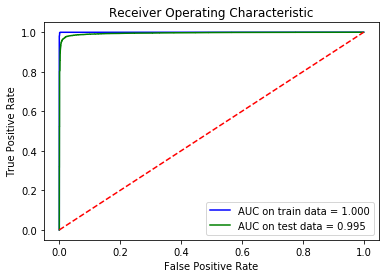

In [267]:
plotROC(Y_train_split_tw, Y_prd_prb_xg_tr_tw,Y_test_tw, Y_prd_prb_xg_ts_tw)

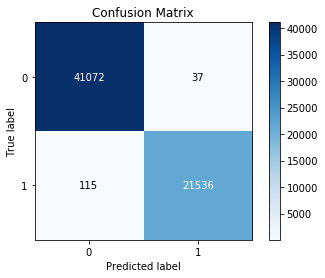

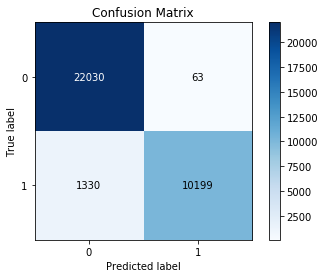

In [268]:
plotConfusion(Y_train_split_tw, Y_prd_xg_tr_tw, Y_test_tw, Y_prd_xg_ts_tw)

In [269]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

print("Precision of test: %0.4f"%(precision_score(Y_test_tw, Y_prd_xg_ts_tw)))
print("Recall of test: %0.4f"%(recall_score(Y_test_tw, Y_prd_xg_ts_tw)))
print("F1 Score of test: %0.4f"%(f1_score(Y_test_tw, Y_prd_xg_ts_tw)))

Precision of test: 0.9939
Recall of test: 0.8846
F1 Score of test: 0.9361


In [271]:
from prettytable import PrettyTable
X = PrettyTable()


X.field_names = ["vectorizer","Classifier","n_estimators", "max_depth","AUC on train","AUC on Test"]
X.add_row(["BoW","Rand. For",200, 50, auc_opt_rf_tr_bow,auc_opt_rf_ts_bow])
X.add_row(["TfIdf","Rand. For",200, 50,auc_opt_rf_tr_tf,auc_opt_rf_ts_tf ])
X.add_row(["Avg W2V","Rand. For",10, 20, auc_opt_rf_ts_aw,auc_opt_rf_tr_aw])
X.add_row(["TfIdf W2V","Rand. For",20, 20, auc_opt_rf_tr_tw, auc_opt_rf_ts_tw])
print(X)

+------------+------------+--------------+-----------+--------------------+--------------------+
| vectorizer | Classifier | n_estimators | max_depth |    AUC on train    |    AUC on Test     |
+------------+------------+--------------+-----------+--------------------+--------------------+
|    BoW     | Rand. For  |     200      |     50    | 0.9936945286363034 | 0.9823628538105236 |
|   TfIdf    | Rand. For  |     200      |     50    | 0.9980787767944306 | 0.9868420690141073 |
|  Avg W2V   | Rand. For  |     100      |     40    | 0.9971517356787404 | 0.9999439260863311 |
| TfIdf W2V  | Rand. For  |     200      |     40    | 0.9999695017462478 | 0.9984896815889943 |
+------------+------------+--------------+-----------+--------------------+--------------------+


In [272]:
from prettytable import PrettyTable
X = PrettyTable()


X.field_names = ["vectorizer","Classifier","n_estimators", "max_depth","AUC on train","AUC on Test"]
X.add_row(["BoW","XGBOOST",200, 50, auc_opt_xg_tr_bow,auc_opt_xg_ts_bow])
X.add_row(["TfIdf","XGBOOST",200, 20,auc_opt_xg_tr_tf,auc_opt_xg_ts_tf ])
X.add_row(["Avg W2V","XGBOOST",200, 40, auc_opt_xg_tr_aw,auc_opt_xg_ts_aw])
X.add_row(["TfIdf W2V","XGBOOST",100, 40, auc_opt_xg_tr_tw, auc_opt_xg_ts_tw])
print(X)

+------------+------------+--------------+-----------+--------------------+--------------------+
| vectorizer | Classifier | n_estimators | max_depth |    AUC on train    |    AUC on Test     |
+------------+------------+--------------+-----------+--------------------+--------------------+
|    BoW     |  XGBOOST   |     200      |     50    | 0.9992510076603226 | 0.9934479288341224 |
|   TfIdf    |  XGBOOST   |     200      |     20    | 0.9974376072657389 | 0.978205446489955  |
|  Avg W2V   |  XGBOOST   |     200      |     40    | 0.9999984668632311 | 0.9975738990137986 |
| TfIdf W2V  |  XGBOOST   |     100      |     40    | 0.9999792326497567 | 0.9952363469767174 |
+------------+------------+--------------+-----------+--------------------+--------------------+


# [6] Conclusions

* In XGBoost, the Bow and tfIdf output performance on train and validation set is not as good as Avg W2v and TFIDF W2V.
* The difference between train and Cv set performance doesnt decrease untill we raise base estimators more than 200 where as in W2V the difference decreases very soon for small value of base estimators and depth.
* Compared to Random Forest, XG Boost takes more time to train.
* As wee can see from above table of Rand. Forest, the BoW and TFIDF has AUC difference train and CV approx. 0.1 and all other vectorizer are doing good on both train and test